In [120]:
# Housing Prices - EDA Notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import numpy as np

# Load training and test data (dowanload the data and place it in data folder for each challenge)
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

# Display basic structure
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

#Lets print the data to see how it looks 
print(train_df.columns)
train_df.head()

# with open("../data/data_description.txt", "r") as f:
#     for line in f:
#         print(line.strip())





Train shape: (1460, 81)
Test shape: (1459, 80)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


| Column Name   | Description                                                   |
|---------------|---------------------------------------------------------------|
| `Id`          | Unique identifier for each property                           |
| `MSSubClass`  | The type of dwelling involved in the sale                     |
| `MSZoning`    | General zoning classification of the sale                     |
| `LotFrontage` | Linear feet of street connected to property                   |
| `LotArea`     | Lot size in square feet                                       |
| `Street`      | Type of road access to the property                           |
| `Alley`       | Type of alley access to the property                          |
| `LotShape`    | General shape of the property                                 |
| `LandContour` | Flatness of the property                                      |
| `Utilities`   | Type of utilities available                                   |
| `LotConfig`   | Lot configuration                                             |
| `LandSlope`   | Slope of the property                                         |
| `Neighborhood`| Physical locations within Ames city limits                    |
| `Condition1`  | Proximity to various conditions                               |
| `Condition2`  | Proximity to various conditions (if more than one is present) |
| `BldgType`    | Type of dwelling                                              |
| `HouseStyle`  | Style of dwelling                                             |
| `OverallQual` | Overall material and finish quality                           |
| `OverallCond` | Overall condition rating                                      |
| `YearBuilt`   | Original construction year                                    |
| `YearRemodAdd`| Year of remodel or addition                                   |
| `RoofStyle`   | Type of roof                                                  |
| `RoofMatl`    | Roof material                                                 |
| `Exterior1st` | Exterior covering on the house                                |
| `Exterior2nd` | Exterior covering on the house (if more than one material)    |
| `MasVnrType`  | Masonry veneer type                                           |
| `MasVnrArea`  | Masonry veneer area in square feet                            |
| `ExterQual`   | Exterior material quality                                     |
| `ExterCond`   | Present condition of exterior material                        |
| `Foundation`  | Type of foundation                                            |
| `BsmtQual`    | Basement height                                               |
| `BsmtCond`    | General basement condition                                    |
| `BsmtExposure`| Walkout or garden level basement walls                        |
| `BsmtFinType1`| Rating of basement finished area                              |
| `BsmtFinSF1`  | Type 1 finished square feet                                   |
| `BsmtFinType2`| Rating of basement finished area (if multiple types)          |
| `BsmtFinSF2`  | Type 2 finished square feet                                   |
| `BsmtUnfSF`   | Unfinished square feet of basement area                       |
| `TotalBsmtSF` | Total square feet of basement area                            |
| `Heating`     | Type of heating                                               |
| `HeatingQC`   | Heating quality and condition                                 |
| `CentralAir`  | Central air conditioning                                      |
| `Electrical`  | Electrical system                                             |
| `1stFlrSF`    | First floor square feet                                       |
| `2ndFlrSF`    | Second floor square feet                                      |
| `LowQualFinSF`| Low quality finished square feet (all floors)                 |
| `GrLivArea`   | Above grade (ground) living area square feet                  |
| `BsmtFullBath`| Basement full bathrooms                                       |
| `BsmtHalfBath`| Basement half bathrooms                                       |
| `FullBath`    | Full bathrooms above grade                                    |
| `HalfBath`    | Half bathrooms above grade                                    |
| `BedroomAbvGr`| Number of bedrooms above basement level                       |
| `KitchenAbvGr`| Number of kitchens                                            |
| `KitchenQual` | Kitchen quality                                               |
| `TotRmsAbvGrd`| Total rooms above grade (does not include bathrooms)          |
| `Functional`  | Home functionality rating                                     |
| `Fireplaces`  | Number of fireplaces                                          |
| `FireplaceQu` | Fireplace quality                                             |
| `GarageType`  | Garage location                                               |
| `GarageYrBlt` | Year garage was built                                         |
| `GarageFinish`| Interior finish of the garage                                 |
| `GarageCars`  | Size of garage in car capacity                                |
| `GarageArea`  | Size of garage in square feet                                 |
| `GarageQual`  | Garage quality                                                |
| `GarageCond`  | Garage condition                                              |
| `PavedDrive`  | Paved driveway                                                |
| `WoodDeckSF`  | Wood deck area in square feet                                 |
| `OpenPorchSF` | Open porch area in square feet                                |
| `EnclosedPorch`| Enclosed porch area in square feet                           |
| `3SsnPorch`   | Three season porch area in square feet                        |
| `ScreenPorch` | Screen porch area in square feet                              |
| `PoolArea`    | Pool area in square feet                                      |
| `PoolQC`      | Pool quality                                                  |
| `Fence`       | Fence quality                                                 |
| `MiscFeature` | Miscellaneous feature not covered in other categories         |
| `MiscVal`     | Value of miscellaneous feature                                |
| `MoSold`      | Month Sold                                                    |
| `YrSold`      | Year Sold                                                     |
| `SaleType`    | Type of sale                                                  |
| `SaleCondition`| Condition of sale                                            |
| `SalePrice`   | Sale price of the house                                       |


In [112]:
# lets havea look how many NaN there are in each column
columns = train_df.columns
for col in columns:
    print('In {} there are {} NaNs'.format(col, train_df[col].isna().sum()))


In Id there are 0 NaNs
In MSSubClass there are 0 NaNs
In MSZoning there are 0 NaNs
In LotFrontage there are 259 NaNs
In LotArea there are 0 NaNs
In Street there are 0 NaNs
In Alley there are 1369 NaNs
In LotShape there are 0 NaNs
In LandContour there are 0 NaNs
In Utilities there are 0 NaNs
In LotConfig there are 0 NaNs
In LandSlope there are 0 NaNs
In Neighborhood there are 0 NaNs
In Condition1 there are 0 NaNs
In Condition2 there are 0 NaNs
In BldgType there are 0 NaNs
In HouseStyle there are 0 NaNs
In OverallQual there are 0 NaNs
In OverallCond there are 0 NaNs
In YearBuilt there are 0 NaNs
In YearRemodAdd there are 0 NaNs
In RoofStyle there are 0 NaNs
In RoofMatl there are 0 NaNs
In Exterior1st there are 0 NaNs
In Exterior2nd there are 0 NaNs
In MasVnrType there are 872 NaNs
In MasVnrArea there are 8 NaNs
In ExterQual there are 0 NaNs
In ExterCond there are 0 NaNs
In Foundation there are 0 NaNs
In BsmtQual there are 37 NaNs
In BsmtCond there are 37 NaNs
In BsmtExposure there are 38

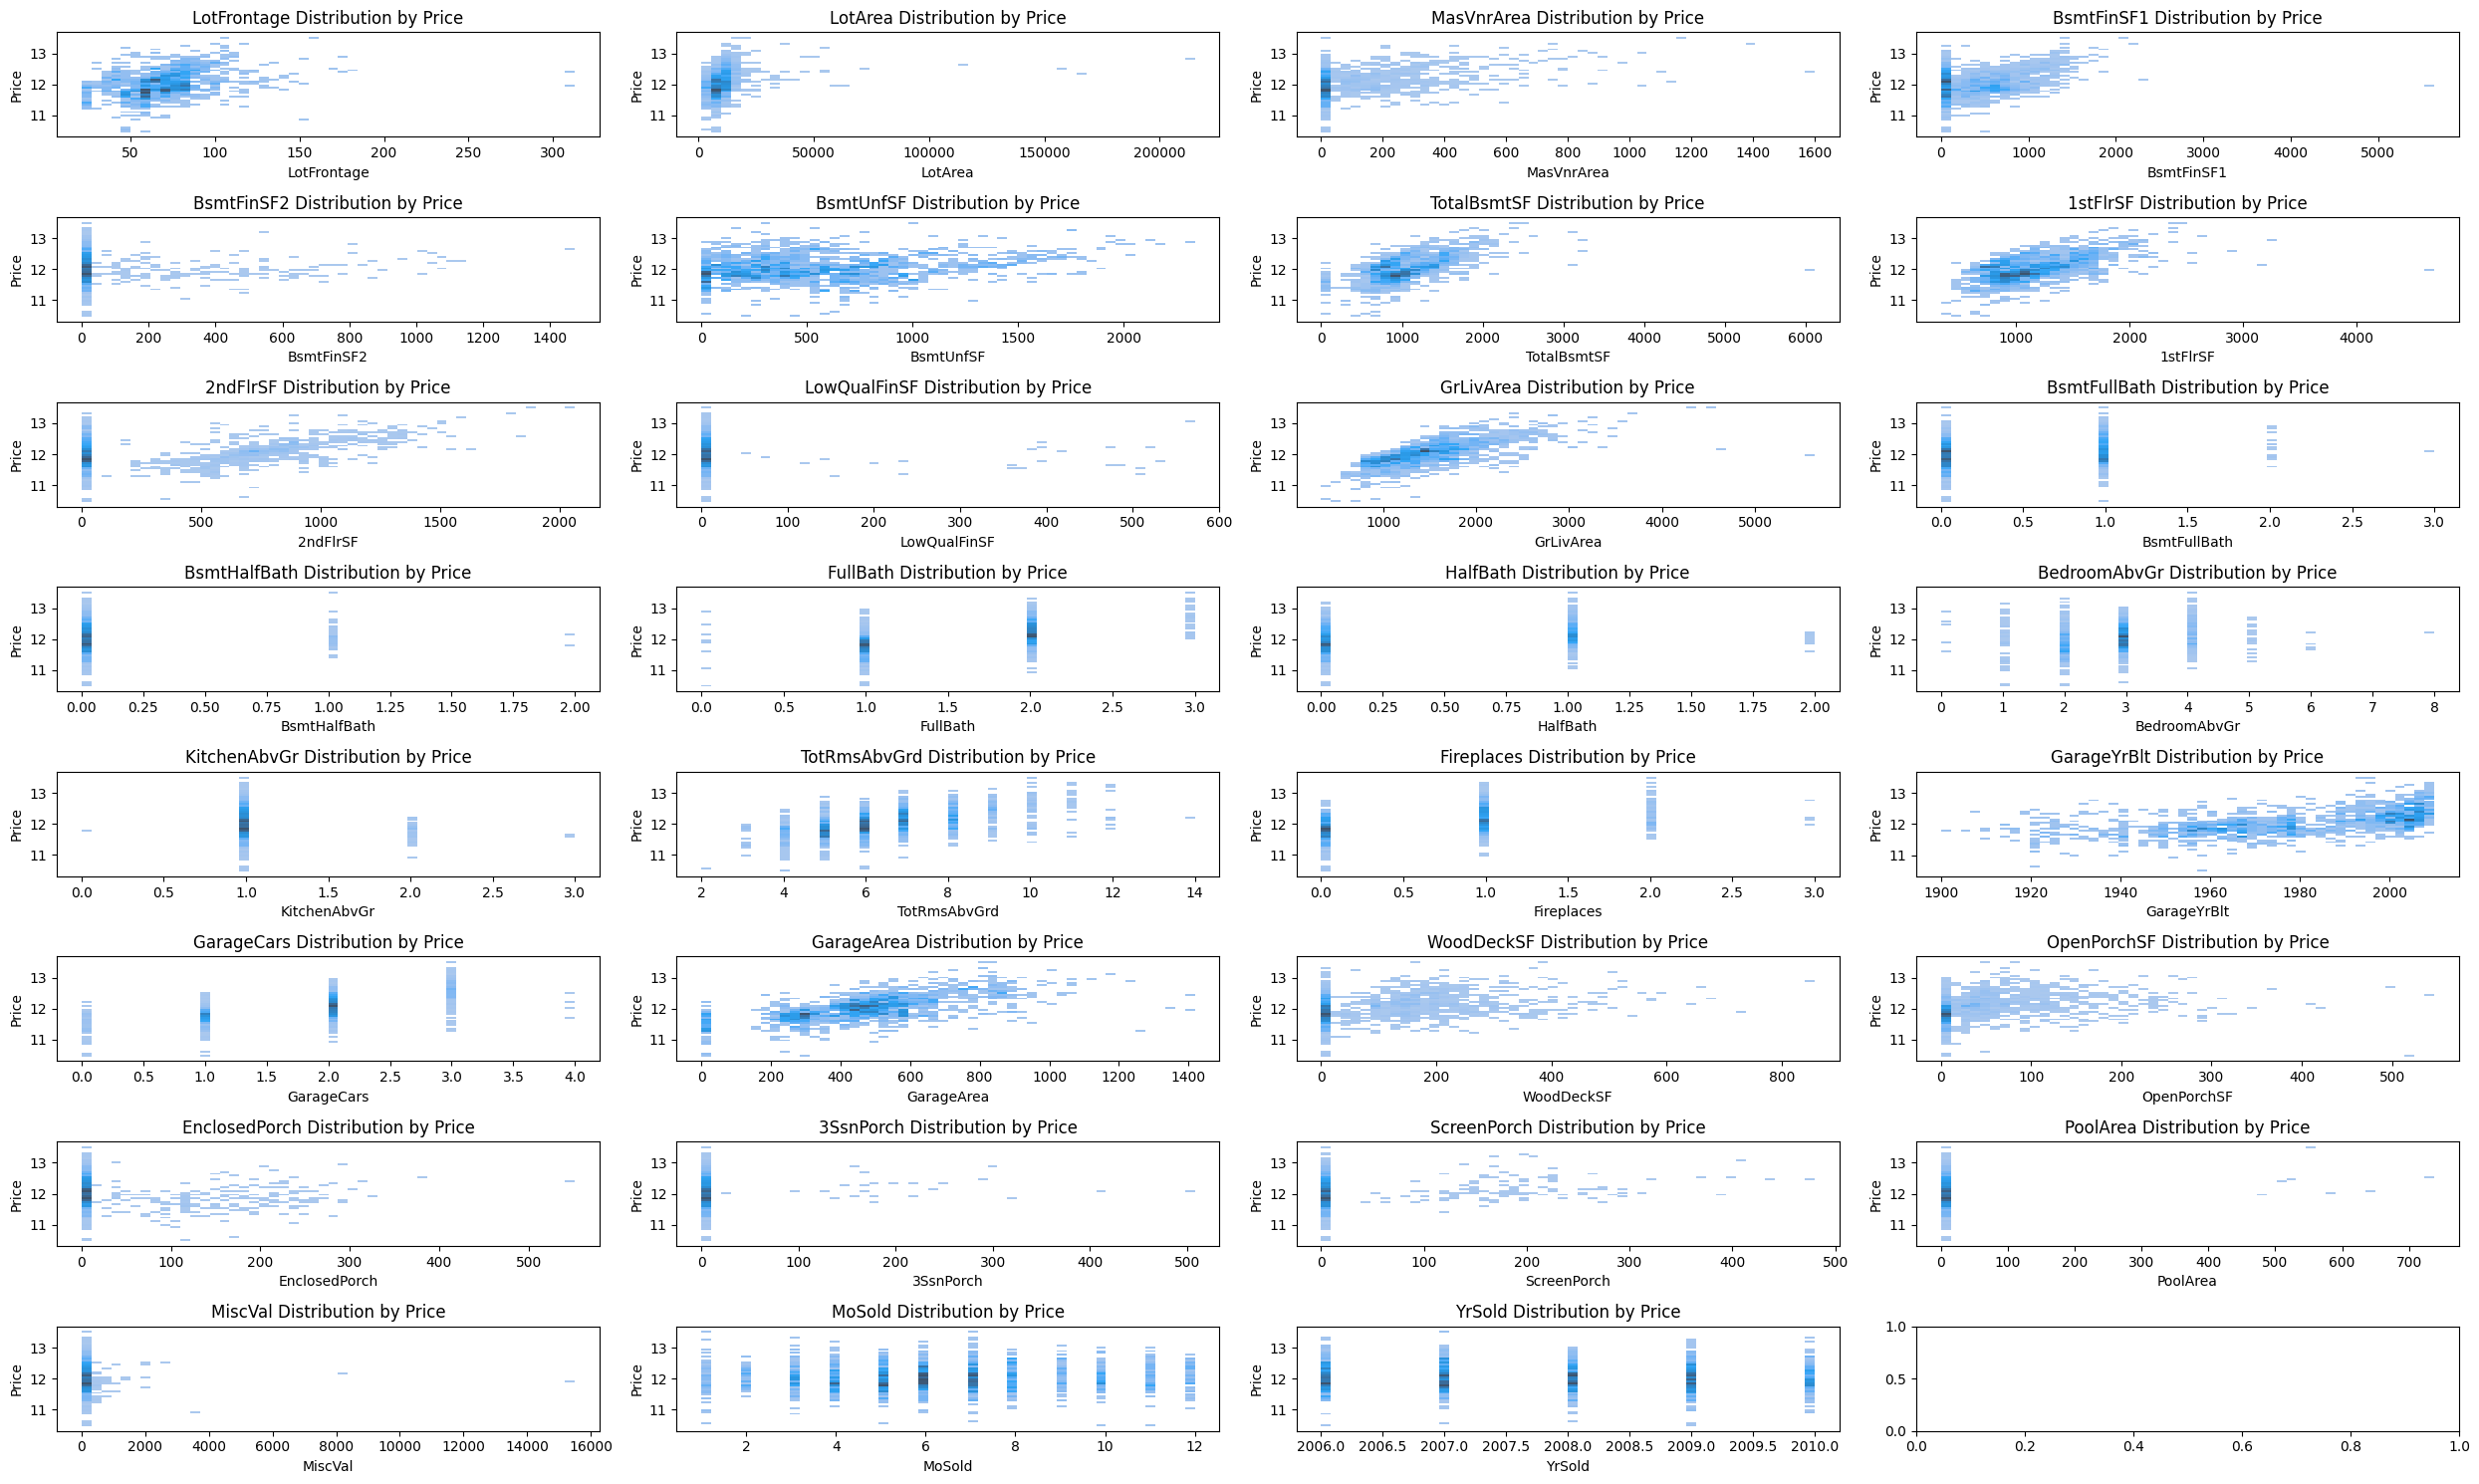

In [121]:
# lets make some histogram plots showing the hue of survival rate over differnt dimensions
fig, ax = plt.subplots(8, 4, figsize=(25, 15))
ax = ax.flatten()
train_df['log_SalePrice'] = np.log(train_df['SalePrice'])

# Pick 6 features you want to explore
columns = [
    "LotFrontage",
    "LotArea",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MoSold",
    "YrSold",
]

for i, col in enumerate(columns):
    sns.histplot(data=train_df, x=col, y='log_SalePrice', ax=ax[i], bins = 50)
    ax[i].set_title(f"{col} Distribution by Price")
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Price")


plt.tight_layout()
plt.show()


In [122]:
# Preprocess 
features = [
    "log_SalePrice",
    "Alley",
    "LotFrontage",
    "LotArea",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MoSold",
    "YrSold",
]
#fill the remaining NaN with the average of the ages 
train_df["LotFrontage"] = train_df["LotFrontage"].fillna(train_df["LotFrontage"].mean())
test_df["LotFrontage"] = test_df["LotFrontage"].fillna(test_df["LotFrontage"].mean())

train_df["MasVnrArea"] = train_df["MasVnrArea"].fillna(train_df["MasVnrArea"].mean())
test_df["MasVnrArea"] = test_df["MasVnrArea"].fillna(test_df["MasVnrArea"].mean())


alley_mapping = {'Grvl': 1, 'Pave': 2}
train_df['Alley'] = test_df['Alley'].map(alley_mapping).fillna(0).astype(int)
test_df['Alley'] = test_df['Alley'].map(alley_mapping).fillna(0).astype(int)

MSZoning_mapping = {'RL': 1, 'RM': 2, 'C (All)': 3, 'FV': 4, 'RH': 5}
train_df['MSZoning'] = test_df['MSZoning'].map(MSZoning_mapping).fillna(0).astype(int)
test_df['MSZoning'] = test_df['MSZoning'].map(MSZoning_mapping).fillna(0).astype(int)

LotShape_mapping = {'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}
train_df['LotShape'] = test_df['LotShape'].map(LotShape_mapping).fillna(0).astype(int)
test_df['LotShape'] = test_df['LotShape'].map(LotShape_mapping).fillna(0).astype(int)

#Garage
GarageType_mapping =  {'Attchd':1, 'Detchd':2, 'BuiltIn':3, 'CarPort':4, 'Attchd':5, 'Detchd':6}
train_df['GarageType'] = test_df['GarageType'].map(GarageType_mapping).fillna(0).astype(int)
test_df['GarageType'] = test_df['GarageType'].map(GarageType_mapping).fillna(0).astype(int)

train_df["GarageYrBlt"] = train_df["GarageYrBlt"].fillna(int(train_df["GarageYrBlt"].mean()))
test_df["GarageYrBlt"] = test_df["GarageYrBlt"].fillna(int(test_df["GarageYrBlt"].mean()))

GarageFinish_mapping =  {'RFn':1, 'Unf':2, 'Fin':3}
train_df["GarageFinish"] = train_df["GarageFinish"].fillna(0)
test_df["GarageFinish"] = test_df["GarageFinish"].fillna(0)

train_df = train_df[features].dropna()

In [123]:
# train_df[features].isna().sum().loc[lambda x: x > 0]
train_df[features]

,log_SalePrice,Alley,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,12.247694,0.0,65.0,8450,196.0,706,0,150,856,856,...,548,0,61,0,0,0,0,0,2,2008
1,12.109011,0.0,80.0,9600,0.0,978,0,284,1262,1262,...,460,298,0,0,0,0,0,0,5,2007
2,12.317167,0.0,68.0,11250,162.0,486,0,434,920,920,...,608,0,42,0,0,0,0,0,9,2008
3,11.849398,0.0,60.0,9550,0.0,216,0,540,756,961,...,642,0,35,272,0,0,0,0,2,2006
4,12.429216,0.0,84.0,14260,350.0,655,0,490,1145,1145,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,12.128111,0.0,62.0,7500,0.0,410,0,811,1221,1221,...,400,0,113,0,0,0,0,0,10,2009
1455,12.072541,0.0,62.0,7917,0.0,0,0,953,953,953,...,460,0,40,0,0,0,0,0,8,2007
1456,12.254863,0.0,85.0,13175,119.0,790,163,589,1542,2073,...,500,349,0,0,0,0,0,0,2,2010
1457,12.493130,0.0,66.0,9042,0.0,275,0,877,1152,1188,...,252,0,60,0,0,0,0,2500,5,2010


RMSE = 32.203097280057335


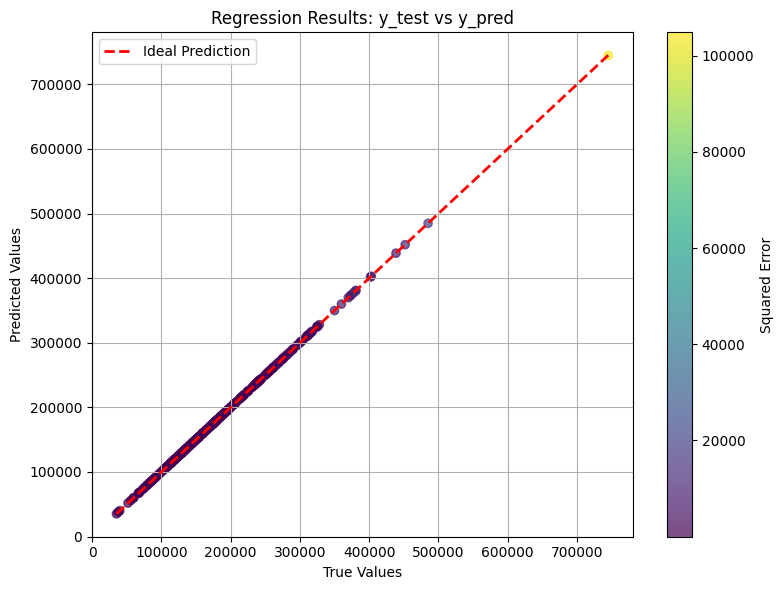

In [134]:
# lets implement a very quick LASSO regression 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.linear_model import Lasso



df = train_df[features]

X = df[features]
y = df["log_SalePrice"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train
clf = Lasso(alpha=1e-4, fit_intercept=True, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=42, selection='random')
clf.fit(X_train_scaled, y_train)

# Predict & Evaluate
y_pred = clf.predict(X_test_scaled)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

y_test, y_pred = np.exp(y_test), np.exp(y_pred)
squared_errors = (y_pred - y_test) ** 2

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE = {}'.format(mse))
plt.figure(figsize=(8, 6))
sc = plt.scatter(y_test, y_pred, c=squared_errors, cmap="viridis", alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Prediction")
plt.colorbar(sc, label="Squared Error")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Regression Results: y_test vs y_pred")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
# plt.xscale('log')
plt.show()


In [16]:
# Now we get the testign data nad prep it for validation: 
test_data = test_df[features]

# lets remove all NaNs for now
# test_data = test_data.dropna()
test_data = test_data[features]
testing_data = scaler.transform(test_data)

# now we see the first predition: 
predicted = clf.predict(testing_data)

#prediction submission: 
sub = {'PassengerId':test_df[features + ["PassengerId"]].dropna()["PassengerId"] , 'Survived': predicted}
sub = pd.DataFrame(sub)
sub.to_csv('../submissions/sub_titanic_v1.csv', index = False)
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [26]:
# lets go a bit indepth: lets try various differnt classifiers
import sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm 

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42)
]

r2_scores = []
accuracy = []

for i, name in tqdm(enumerate(names)):
    clf = classifiers[i].fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    r2_scores.append(sklearn.metrics.r2_score(y_test, y_pred))
    accuracy.append(sklearn.metrics.accuracy_score(y_test, y_pred))


8it [00:04,  1.91it/s]


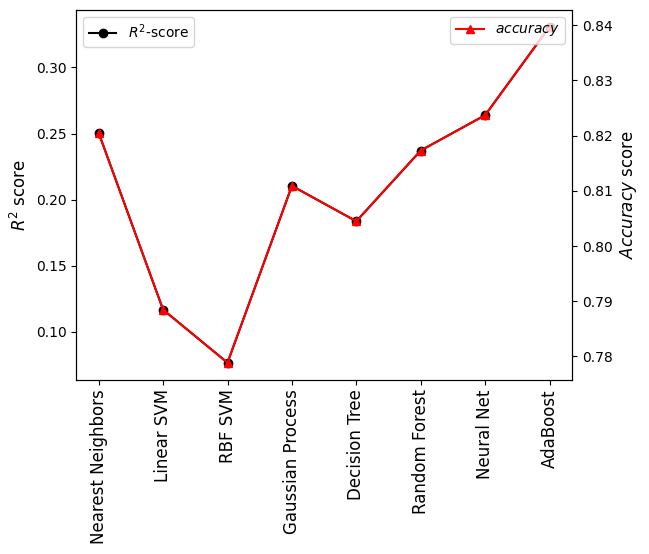

In [27]:
import numpy as np
fig, ax1 = plt.subplots() 
x = np.arange(0, len(names))

ax1.plot(r2_scores, '-ok', label = '$R^{2}$-score')
ax1.set_ylabel(r'$R^{2}$ score', fontsize = 12)

ax2 = ax1.twinx() 
ax2.plot(accuracy, '-^r', label = '$accuracy$')
ax1.set_xticks(x, names, fontsize = 12, rotation=90)
ax2.set_ylabel(r'$Accuracy$ score', fontsize = 12)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')


